## OVERVIEW

In this application, I explored a dataset from kaggle.
The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing. My goal was to understand what factors make a car more or less expensive. As a result of my analysis provide clear recommendations to a client -- a used car dealership -- as to what consumers value in a used car.

In [355]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [360]:
# Set display option to show full numeric values (suppress scientific notation)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Business Understanding
From a business perspective, we are tasked with identifying key drivers for used car prices.
- In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition. Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

### Load Data

In [642]:
# import data
data = pd.read_csv('data/vehicles.csv')

In [643]:
# DataFrame Shape
print(f'DataFrame shape: {data.shape}\n')

# Data Types
data.info()

DataFrame shape: (426880, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426

##### Datraframe has the following columns
- id: A unique identifier for each listing.
- region: The geographical region of the listing.
- price: The listed price of the vehicle. (y feature)
- year: The manufacturing year of the vehicle.
- manufacturer: The manufacturer of the vehicle.
- model: The model of the vehicle.
- condition: The condition of the vehicle.
- cylinders: Information about the vehicle's engine cylinders.
- fuel: The type of fuel the vehicle uses.
- odometer: The vehicle's odometer reading.
- title_status: The status of the vehicle's title.
- transmission: The type of transmission in the vehicle.
- VIN: The Vehicle Identification Number.
- drive: The drive type of the vehicle (e.g., front-wheel, rear-wheel).
- size: The size of the vehicle.
- type: The type of vehicle (e.g., SUV, sedan).
- paint_color: The color of the vehicle.
- state: The state where the vehicle is listed.

In [363]:
# Sample data
data.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
16318,7311617791,tucson,29995,2017.000,ford,super duty f-250 srw,excellent,8 cylinders,gas,87232.000,clean,automatic,1FTBF2A67HEB48148,rwd,full-size,pickup,white,az
129161,7315085074,hawaii,10000,2012.000,ram,cargo van,NaN,6 cylinders,gas,79931.000,clean,automatic,2C4JDGAG9CR317900,fwd,NaN,van,white,hi
363395,7303238642,amarillo,10995,2017.000,kia,forte5,like new,4 cylinders,gas,38524.000,clean,automatic,NaN,fwd,full-size,wagon,silver,tx
410731,7317018253,spokane / coeur d'alene,17987,2014.000,ford,escape titanium,good,NaN,gas,81819.000,clean,other,1FMCU9J9XEUD60715,NaN,NaN,other,blue,wa
235387,7303612397,eastern NC,24590,2018.000,lincoln,mkz select sedan 4d,good,NaN,gas,16081.000,clean,automatic,3LN6L5C91JR615484,fwd,NaN,sedan,white,nc


#### Basic data cleanning and columns drops

In [364]:
# Number of rows where price is equal to or less than 0
print('Number of rows where price is equal to or less than 0:', len(data.query('price <= 0').sort_values(by='price',ascending=False)))

Number of rows where price is equal to or less than 0: 32895


In [365]:
# Drop rows where price is equal to or less than 0
data.drop(data.query('price <= 0').index, inplace=True)

In [366]:
data.shape

(393985, 18)

In [367]:
data.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
397978,7316274189,roanoke,10995,2000.000,lexus,lx 470 4wd,excellent,8 cylinders,gas,226080.000,clean,automatic,JT6HT00WXY0112127,4wd,full-size,SUV,white,va
21345,7315732616,bakersfield,15000,2005.000,chevrolet,silverado,NaN,NaN,gas,115532.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
306456,7310142679,oklahoma city,38500,1974.000,NaN,plymouth barracuda,NaN,NaN,gas,48156.000,clean,manual,NaN,NaN,NaN,NaN,NaN,ok
155702,7301653982,ames,26031,2015.000,ford,f-150,NaN,NaN,gas,153092.000,clean,automatic,1FTEW1EG8FKD79827,4wd,NaN,NaN,NaN,ia
246188,7311743332,elko,23950,2017.000,ram,1500 laramie 4x4,NaN,8 cylinders,gas,94921.000,rebuilt,automatic,NaN,4wd,NaN,truck,white,nv


### Data Understanding (Exploratory Data Analysis)

After considering the business understanding, let's get familiar with the data.

#### Missing data

In [368]:
# Calculate the percentage of missing data for each column
missing_data_percentage = data.isnull().mean() * 100

# Print the percentage of missing data
print(missing_data_percentage.sort_values(ascending=False))

size           71.813
cylinders      40.715
VIN            38.620
condition      38.425
drive          30.522
paint_color    29.734
type           21.811
manufacturer    4.108
title_status    1.963
model           1.193
fuel            0.658
odometer        0.581
transmission    0.463
year            0.298
region          0.000
id              0.000
price           0.000
state           0.000
dtype: float64


In [369]:
# Count the number of unique values in each column
unique_data_percentage = data.nunique()

# Print the count of unique values
print(unique_data_percentage)

id              393985
region             404
price            15654
year               113
manufacturer        42
model            28265
condition            6
cylinders            8
fuel                 5
odometer         98801
title_status         6
transmission         3
VIN             105811
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64


#### Price analysis

In [370]:
data['price'].describe()

count       393985.000
mean         81477.628
std       12680636.885
min              1.000
25%           7000.000
50%          15000.000
75%          27590.000
max     3736928711.000
Name: price, dtype: float64

<Axes: xlabel='price'>

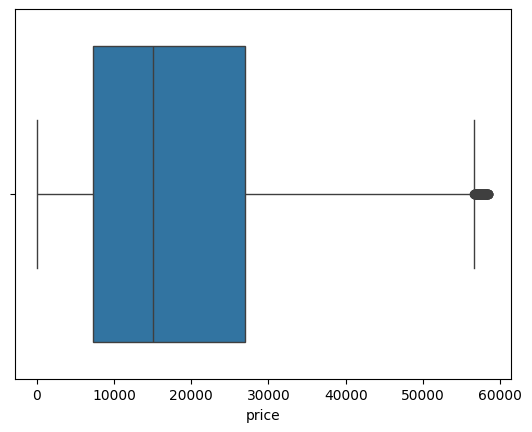

In [371]:
sns.boxplot(x=filtered_data['price'])

<Axes: xlabel='odometer', ylabel='price'>

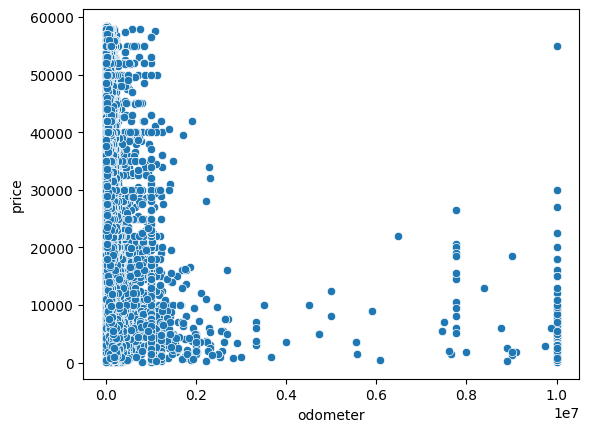

In [372]:
sns.scatterplot(y=filtered_data['price'],x=filtered_data['odometer'])

In [373]:
data.query('price < 900 or price > 1000000').sort_values(by='price',ascending=False)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.000,toyota,tundra,excellent,8 cylinders,gas,164000.000,clean,automatic,NaN,4wd,full-size,pickup,silver,or
356716,7302445002,knoxville,3736928711,1999.000,toyota,4runner,fair,6 cylinders,gas,211000.000,clean,automatic,NaN,4wd,mid-size,NaN,green,tn
91576,7309730903,delaware,3024942282,2000.000,mercedes-benz,benz e320,NaN,NaN,gas,100000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,de
257840,7309735768,south jersey,3024942282,2000.000,mercedes-benz,benz s430,NaN,NaN,gas,100000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
37410,7314052904,modesto,3009548743,2021.000,chevrolet,NaN,NaN,8 cylinders,gas,1000.000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218548,7313391201,jackson,1,2015.000,lexus,es 350,NaN,6 cylinders,gas,102000.000,clean,automatic,JTHBK1GG5F2205885,rwd,full-size,sedan,silver,ms
218633,7308150616,jackson,1,1964.000,NaN,1964 Oldsmobile,NaN,NaN,gas,1000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,ms
218717,7302774597,jackson,1,2015.000,lexus,es 350,NaN,6 cylinders,gas,102000.000,clean,automatic,JTHBK1GG5F2205885,rwd,full-size,sedan,silver,ms
2493,7302964120,gadsden-anniston,1,2012.000,chevrolet,malibu,NaN,NaN,gas,268000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,al


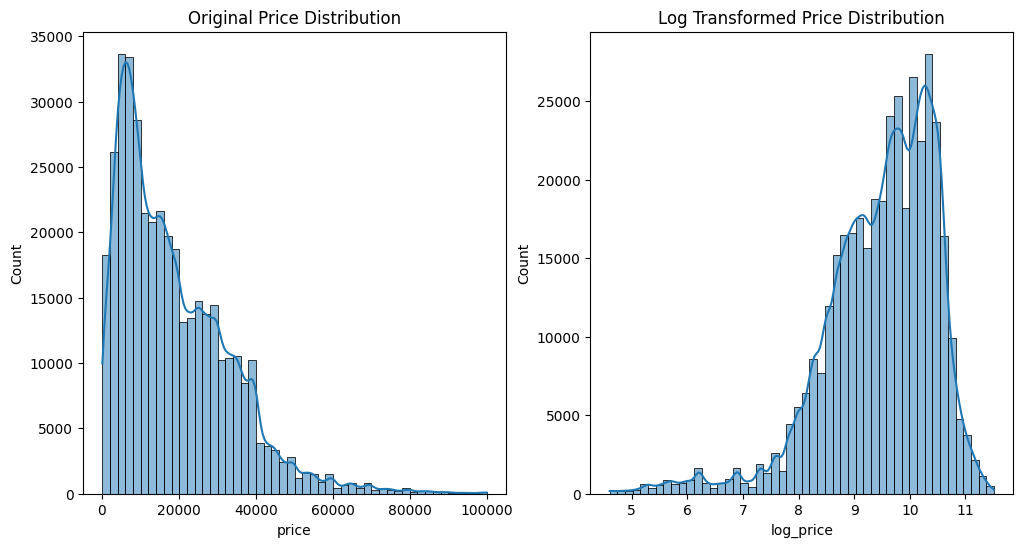

In [554]:
# Considering 'price' is right skewed, I transformed the price using log.
data1 = data[(data['price'] <= 100000) & (data['price'] >= 100)].copy()
data1['log_price'] = np.log(data['price'])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data1['price'], bins=50, kde=True)
plt.title('Original Price Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data1['log_price'], bins=50, kde=True)
plt.title('Log Transformed Price Distribution')

plt.show()



In [555]:
skewness = data1['log_price'].skew()
print("Skewness of Log Transformed Prices:", skewness)

Skewness of Log Transformed Prices: -1.2353837234903569


In [556]:
data1['price'].describe()

count   390003.000
mean     18877.350
std      14486.774
min        100.000
25%       7495.000
50%      15500.000
75%      27800.000
max     100000.000
Name: price, dtype: float64

In [557]:
baseline_mean = data1['price'].mean()
baseline_mean

18877.350476791205

### Average price by region, state, year, transmission, odometer, fuel, model, title_status, manufacturer

In [585]:
# function to plot the average price of a feature
def plot_avg_price_feature(df, feature):

    # calulate the avereage price by feature
    avg_price_region = data1.groupby(feature).agg({'price':'mean','id':pd.Series.nunique}).reset_index().sort_values(by='price',ascending=False)

    # calculate the avearage quantity by feature
    avg_quantity_feature = (df[feature].value_counts(normalize=True,ascending=False)*100).mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(30,5))

    plt.suptitle(f'Average price by {feature}')
    
    sns.barplot(data=avg_price_region, x=feature, y='price',ax=axes[0])
    axes[0].tick_params(labelrotation=90)
    axes[0].ticklabel_format(style='plain', axis='y')
    axes[0].axhline(baseline_mean, color='r')

    sns.countplot(data=df, x=feature, ax=axes[1], order=df[feature].value_counts(ascending=False).index, stat='percent')
    axes[1].tick_params(labelrotation=90)
    axes[1].ticklabel_format(style='plain', axis='y')
    axes[1].axhline(avg_quantity_feature, color='r') 
    
    plt.plot()

In [602]:
def plot_box_price_feature(df,feature):

    
    fig, axes = plt.subplots(1,2,figsize=(30,5))

    sns.boxplot(x=df[feature],y=df['price'],ax=axes[0])
    axes[0].tick_params(labelrotation=90)
    axes[0].ticklabel_format(style='plain', axis='y')
    axes[0].set_title('With outliers')
    
    sns.boxplot(x=df[feature],y=df['price'],showfliers = False, ax=axes[1])
    axes[1].tick_params(labelrotation=90)
    axes[1].ticklabel_format(style='plain', axis='y')
    axes[1].set_title('Without outliers')
    
    plt.suptitle(f'Price Boxplot by {feature}')
    
    plt.plot()

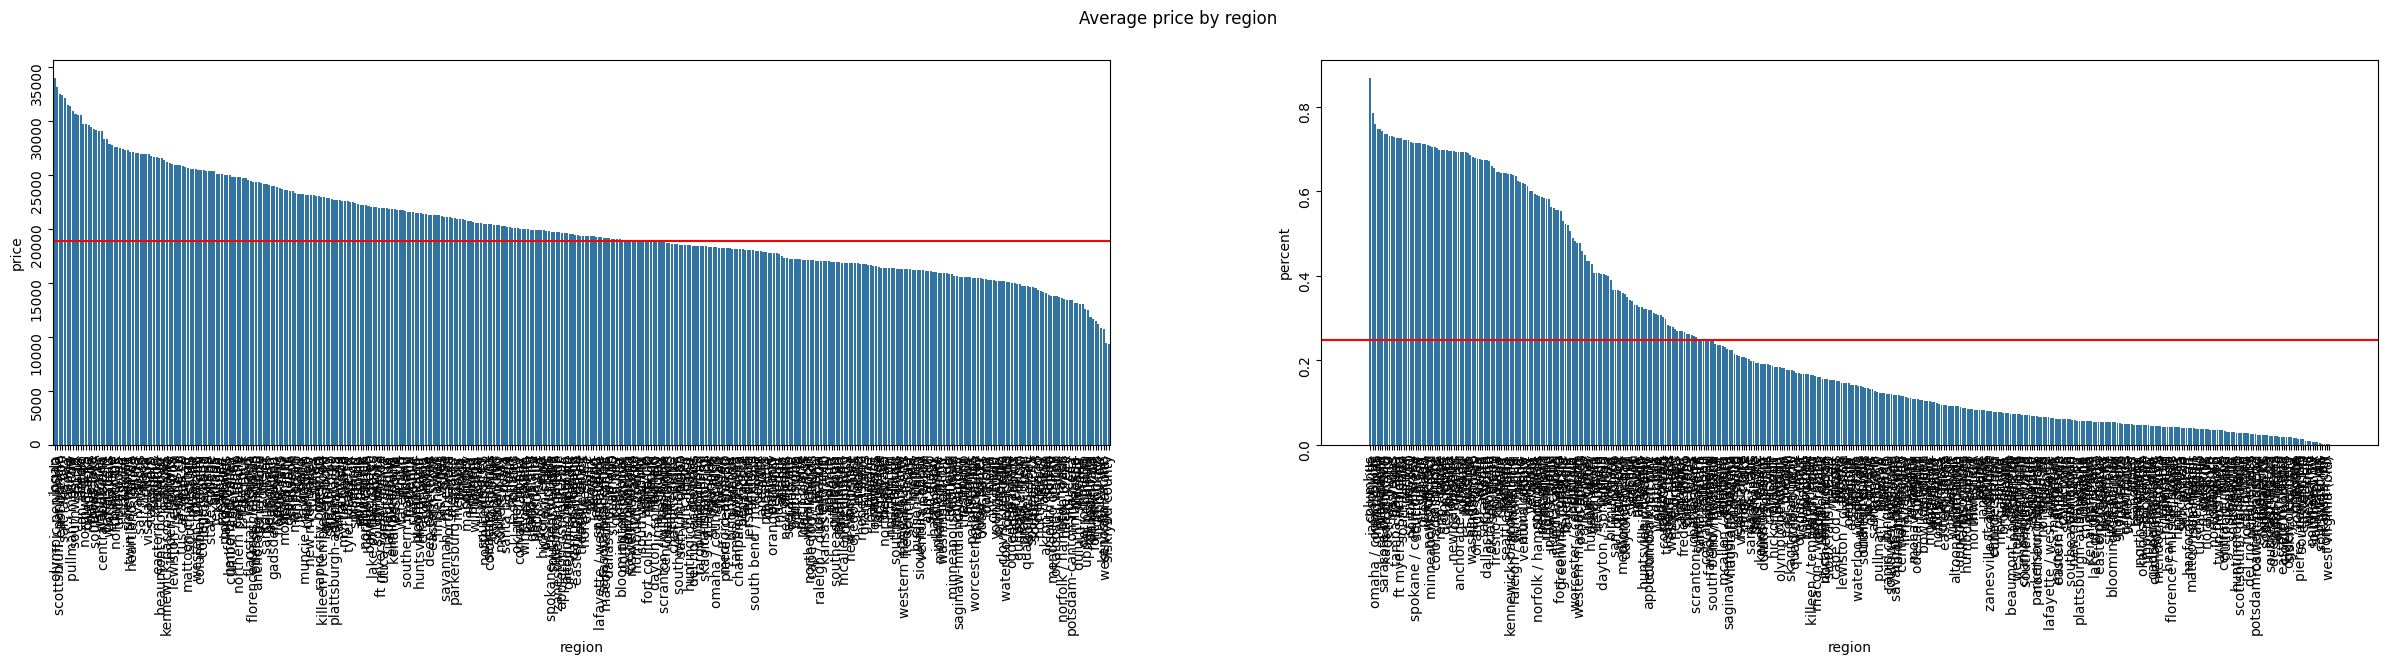

In [587]:
# by region
plot_avg_price_feature(data1,'region')

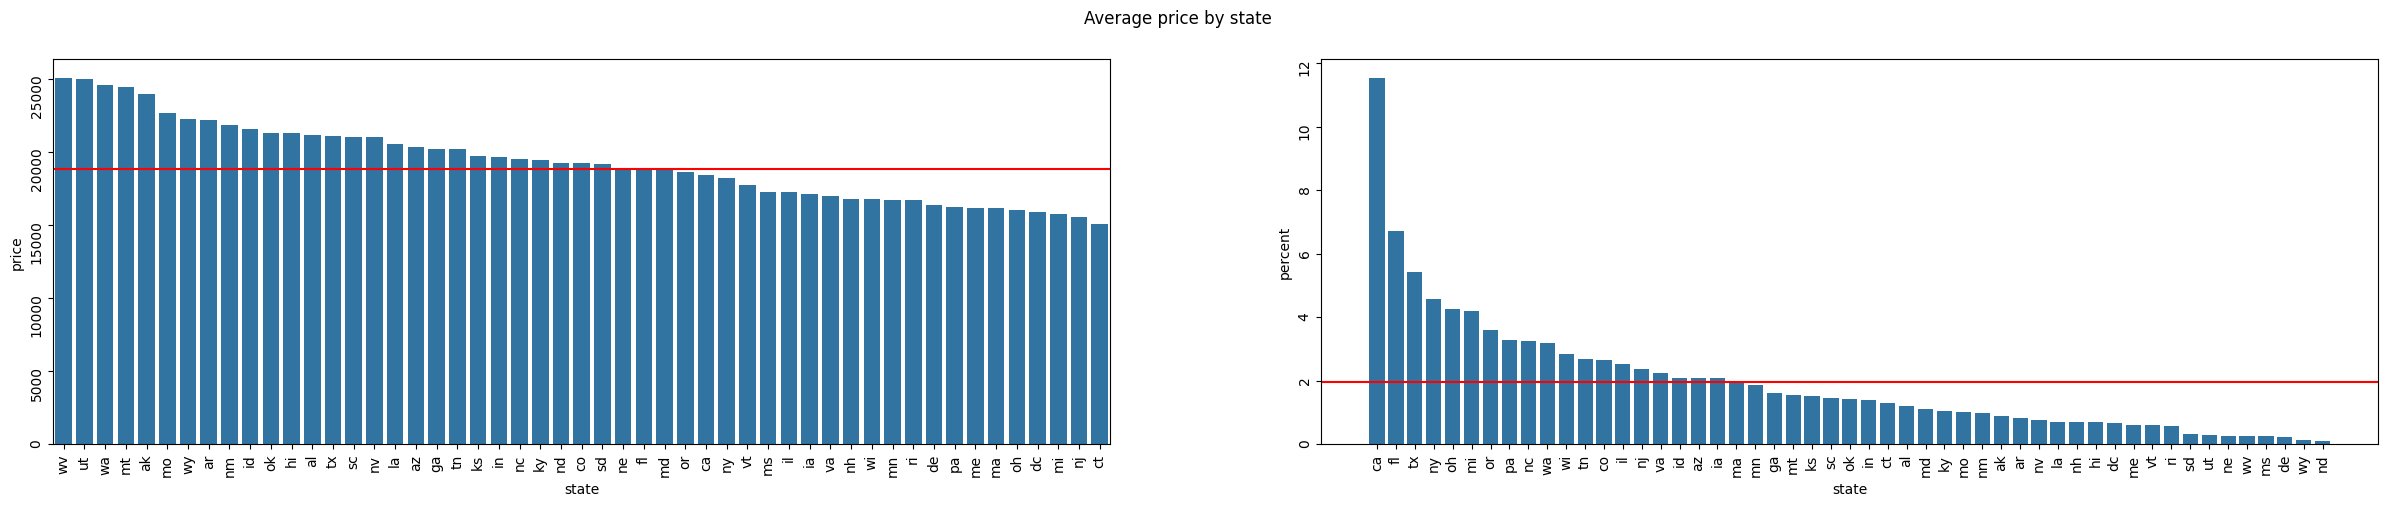

In [588]:
# by state
plot_avg_price_feature(data1,'state')

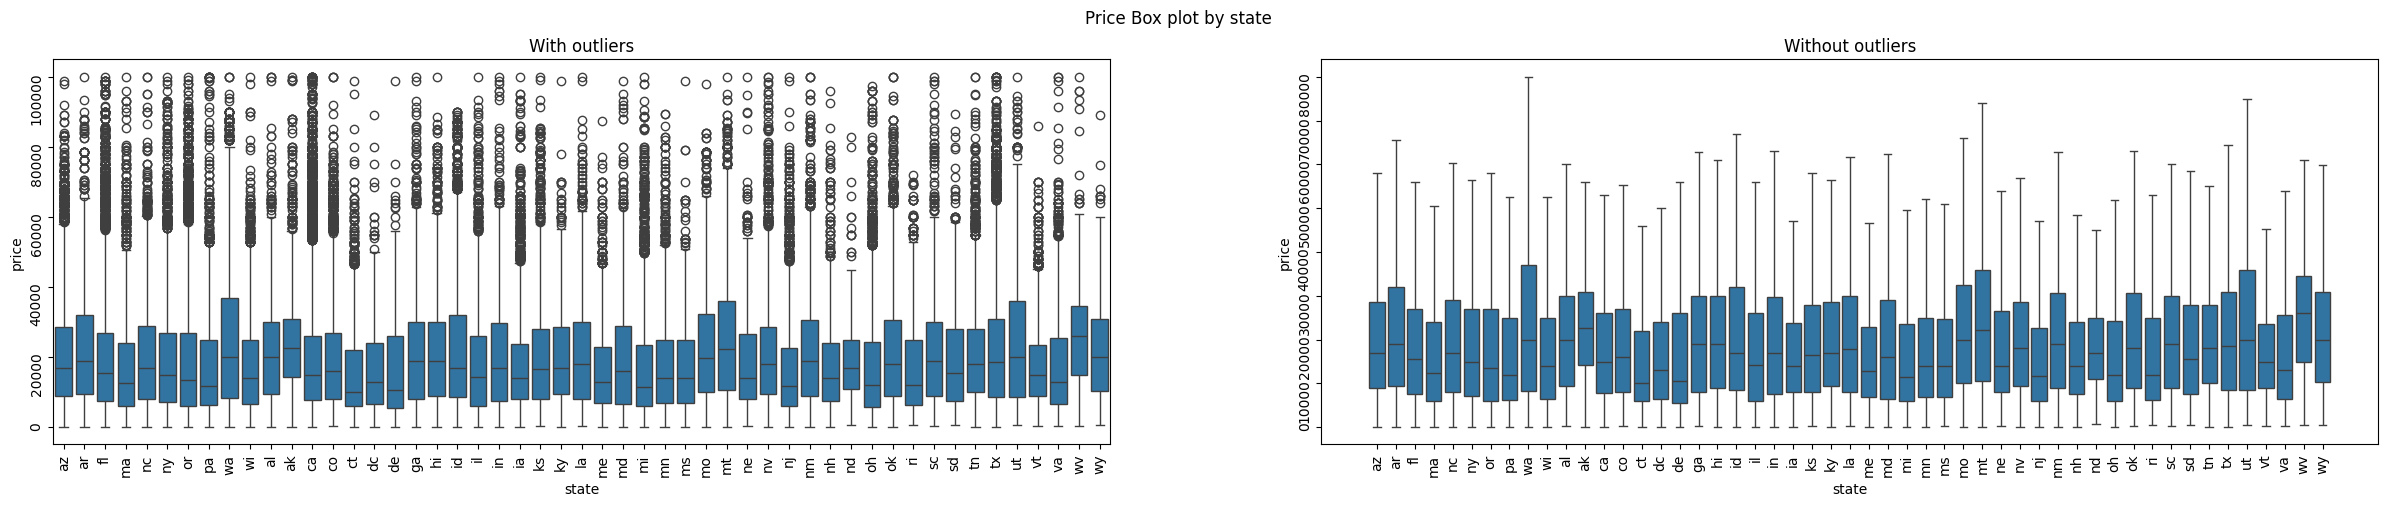

In [589]:
plot_box_price_feature(data1,'state')

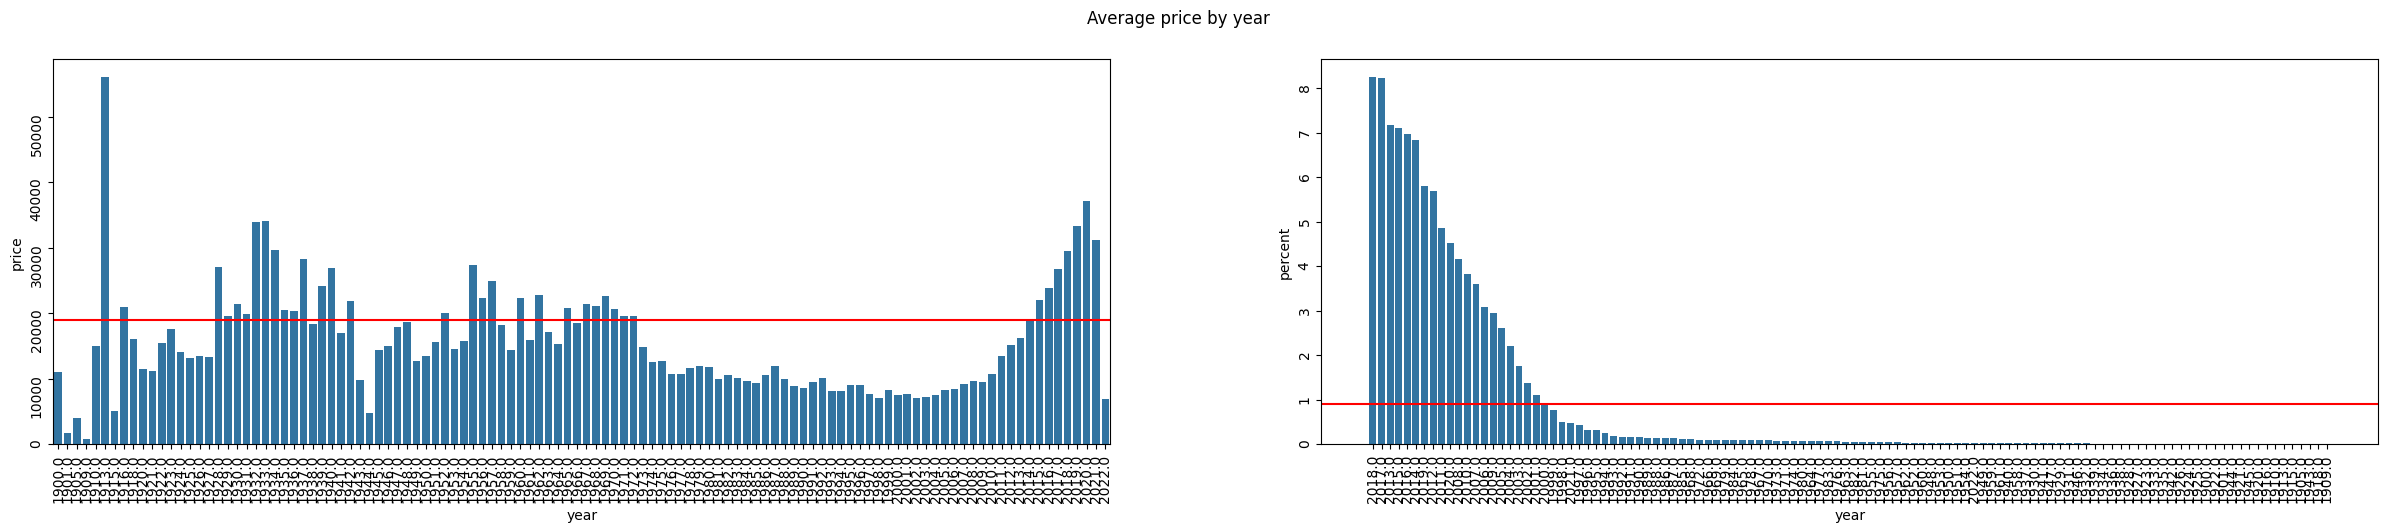

In [590]:
# by year
plot_avg_price_feature(data1,'year')

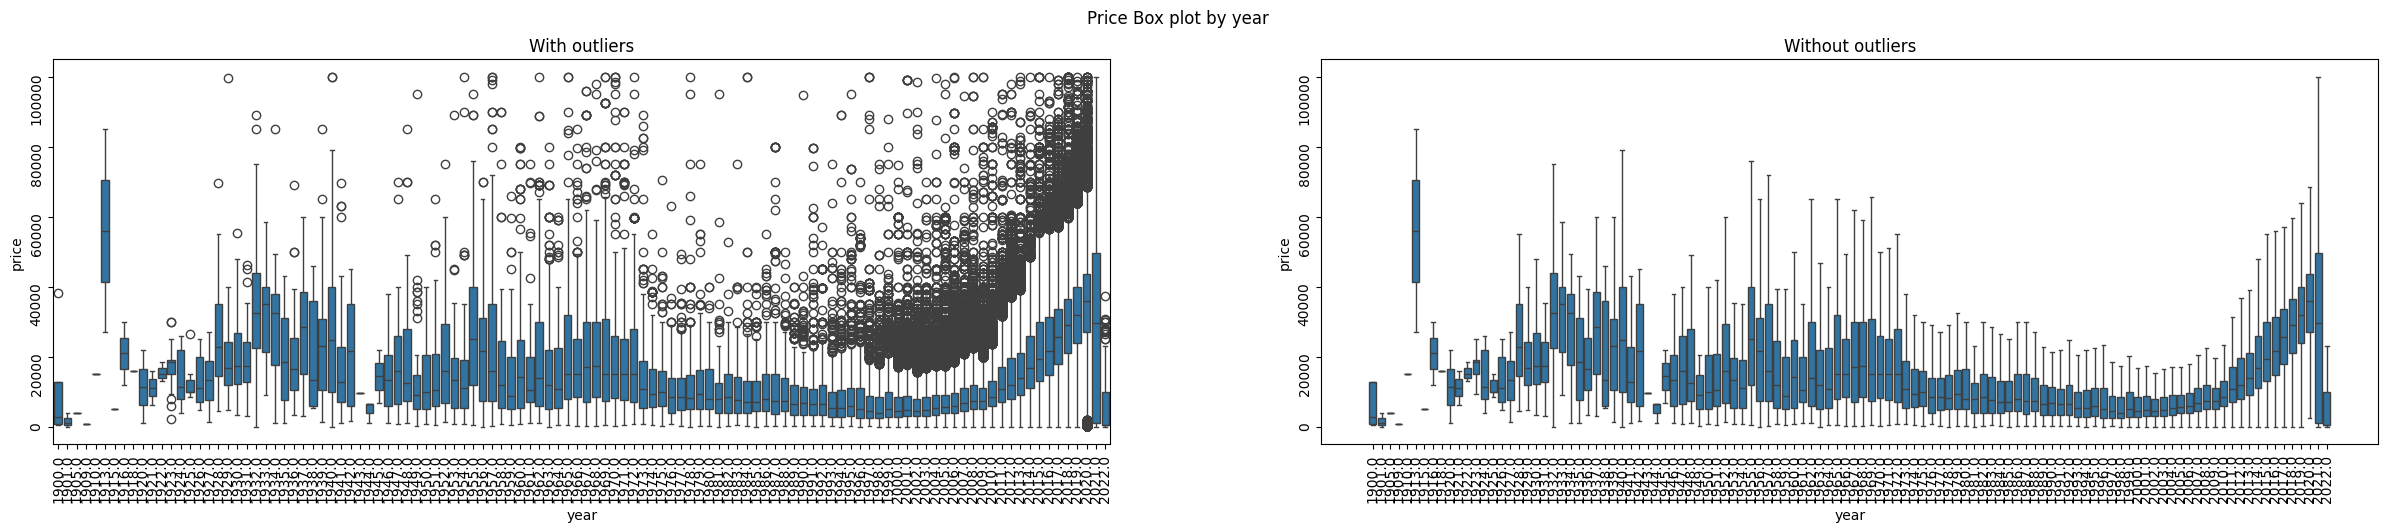

In [591]:
plot_box_price_feature(data1,'year')

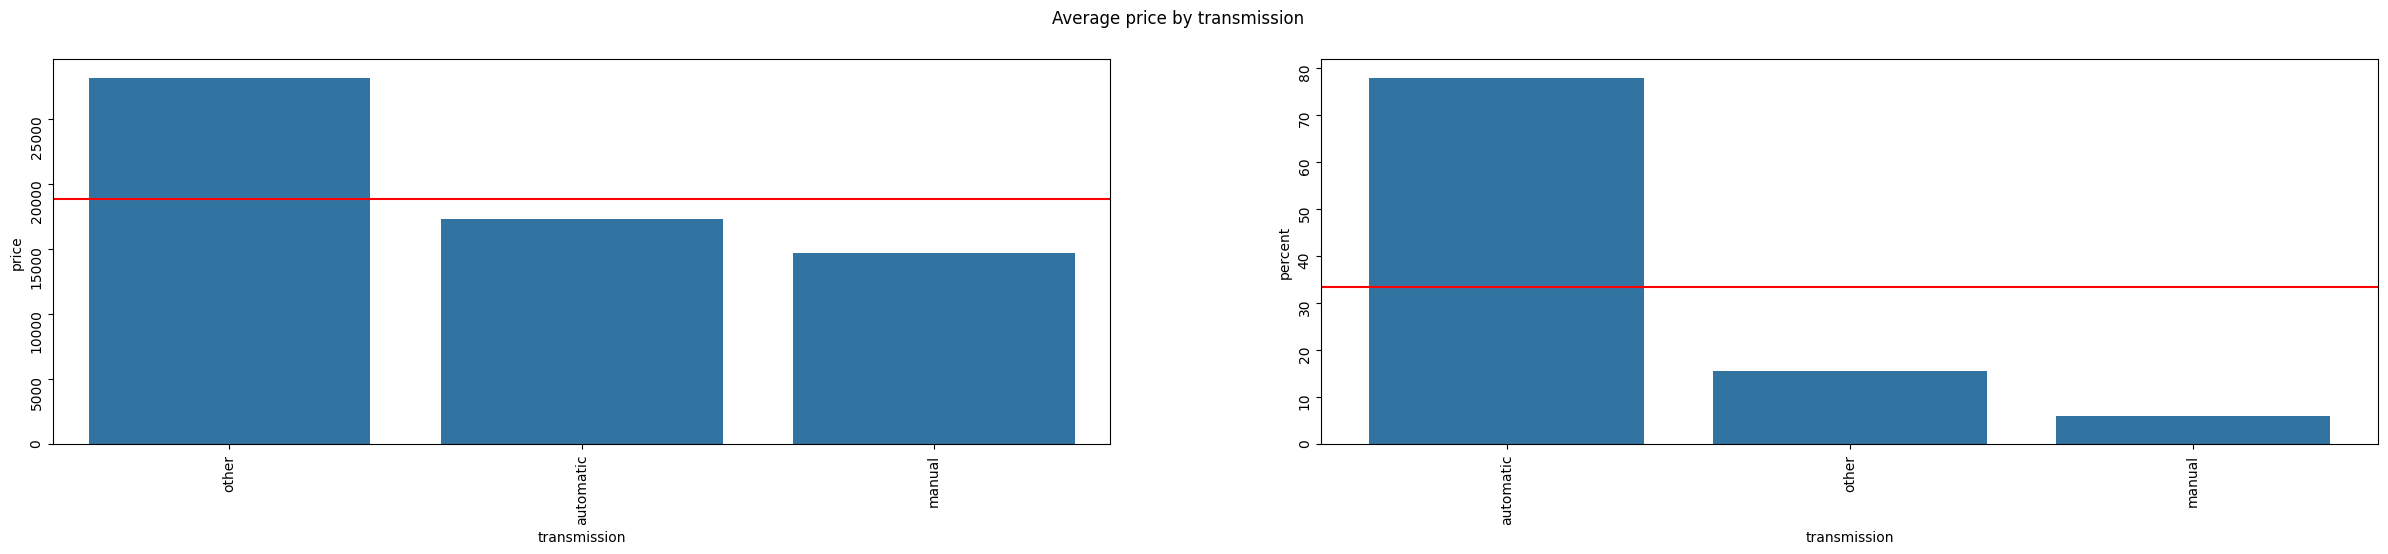

In [592]:
# by transmission
plot_avg_price_feature(data1,'transmission')

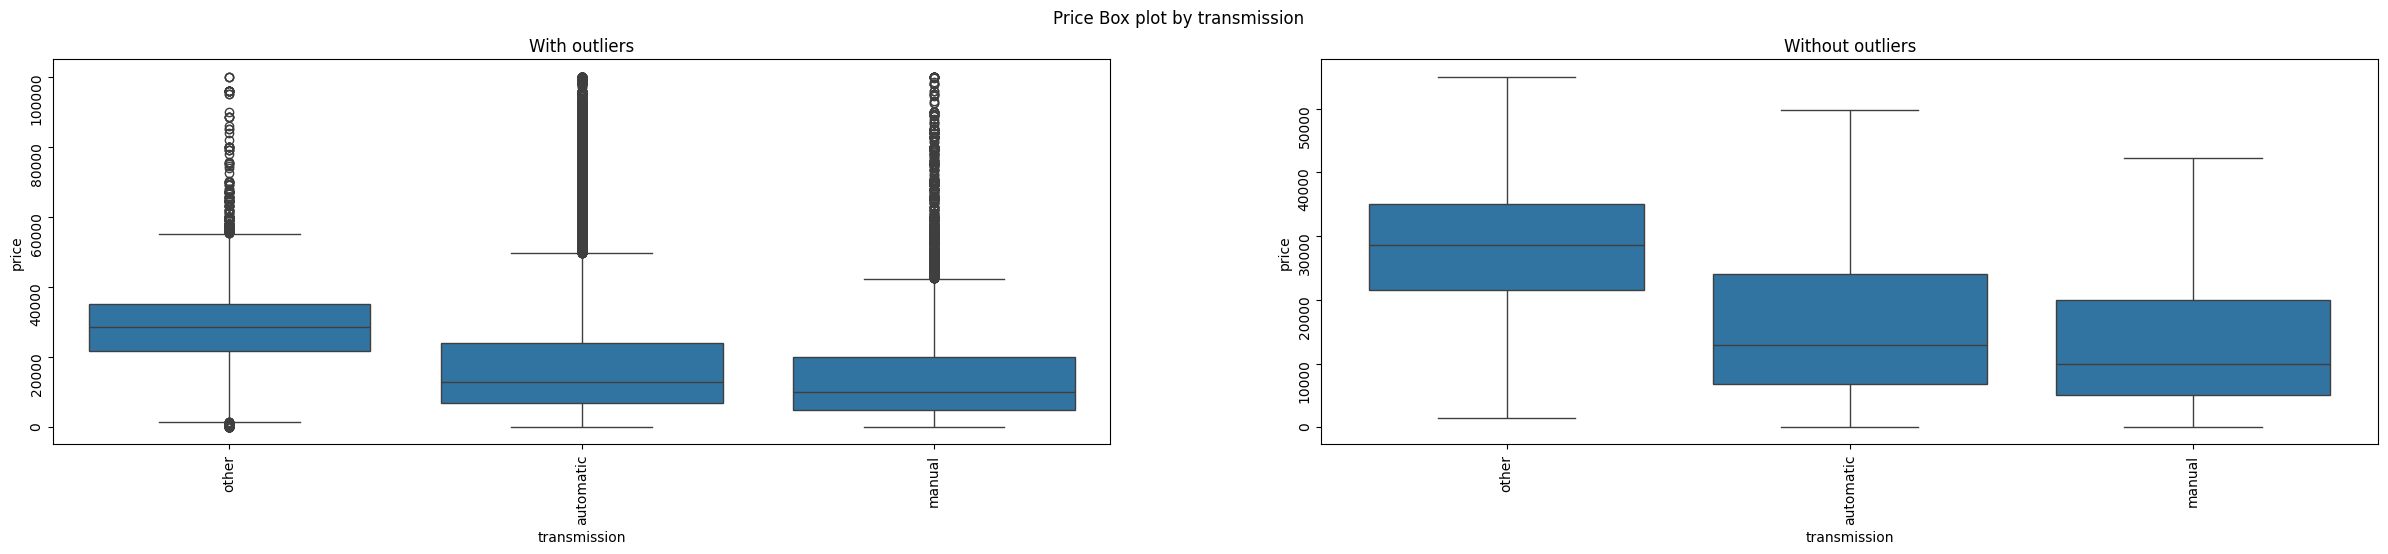

In [593]:
plot_box_price_feature(data1,'transmission')

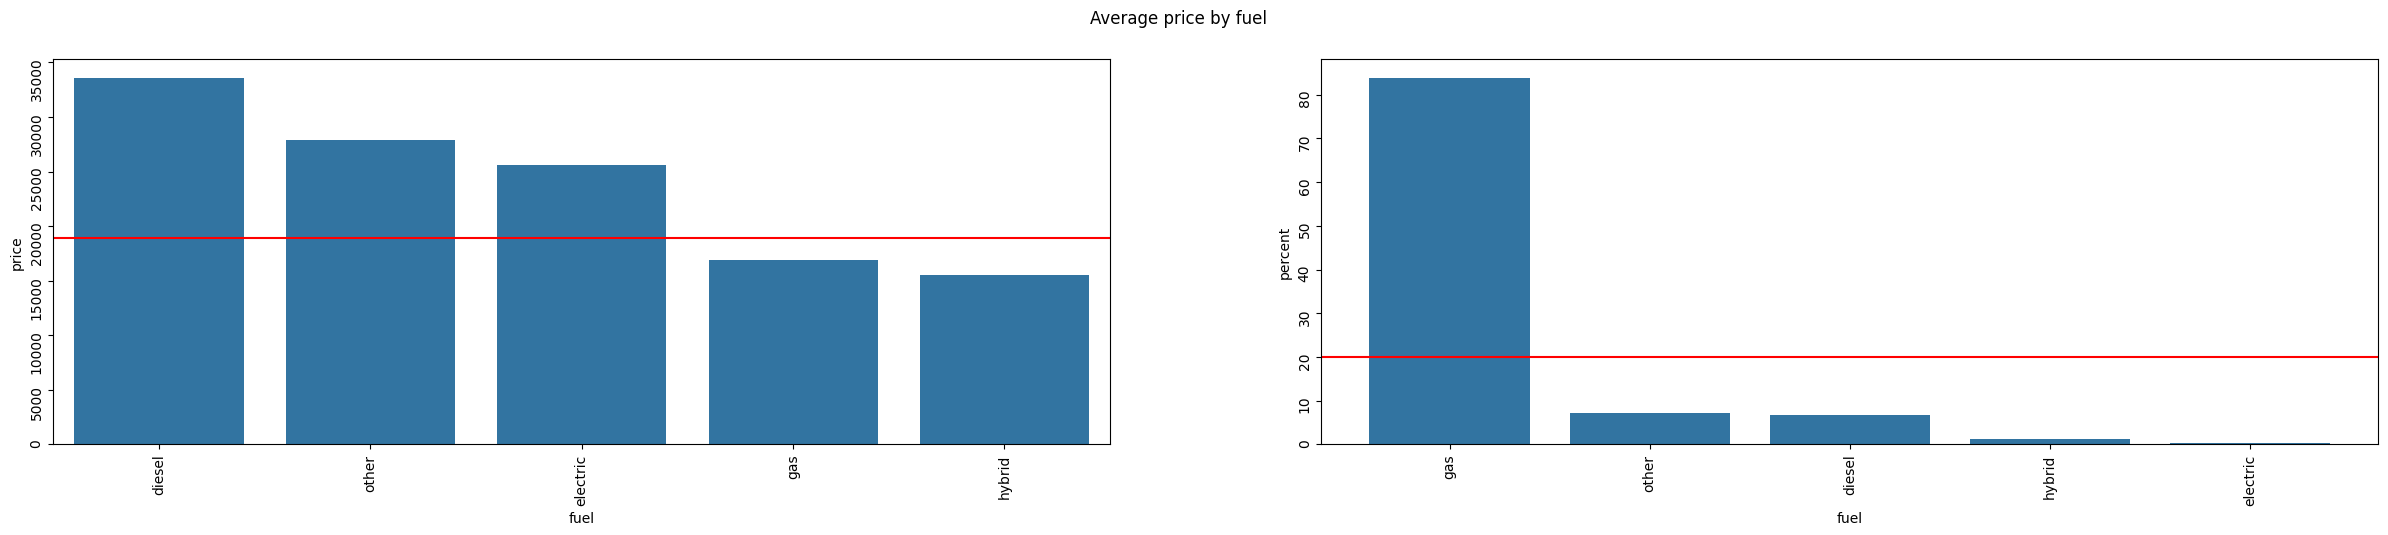

In [594]:
# by fuel
plot_avg_price_feature(data1,'fuel')

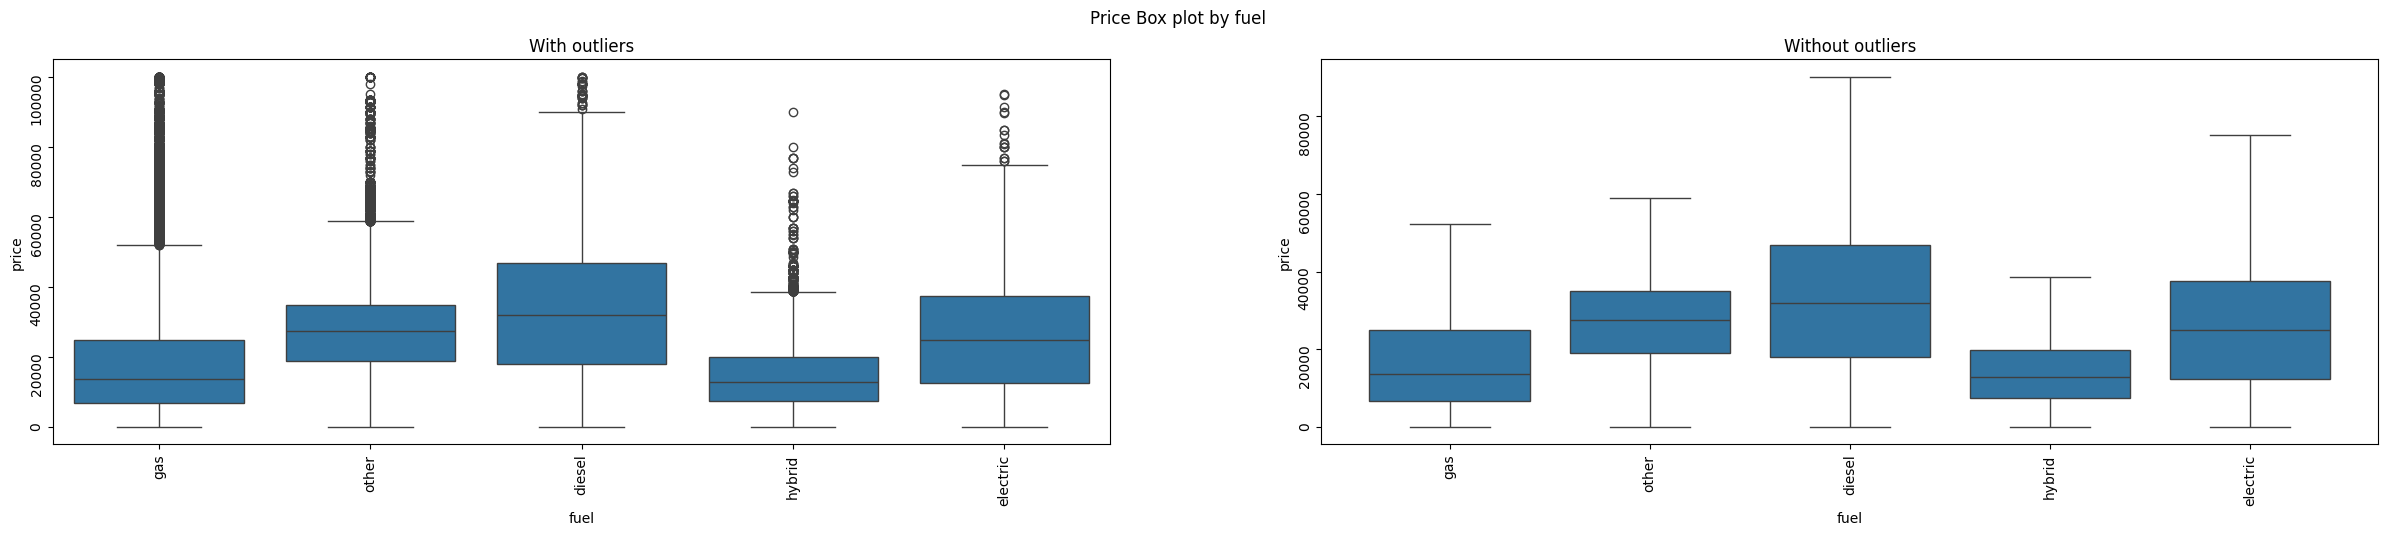

In [595]:
plot_box_price_feature(data1,'fuel')

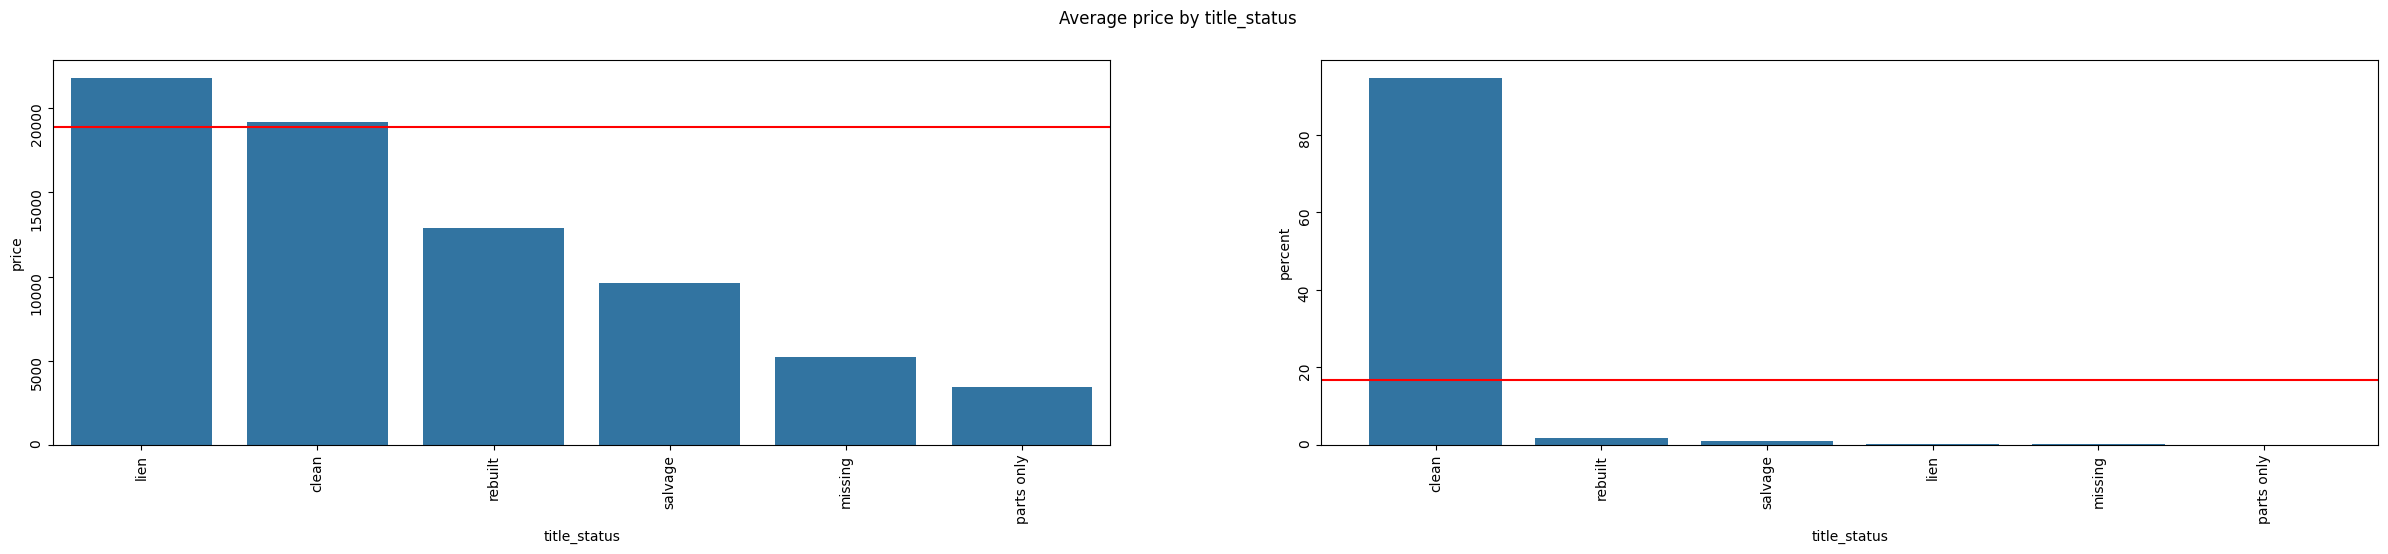

In [596]:
# by title_status
plot_avg_price_feature(data1,'title_status')

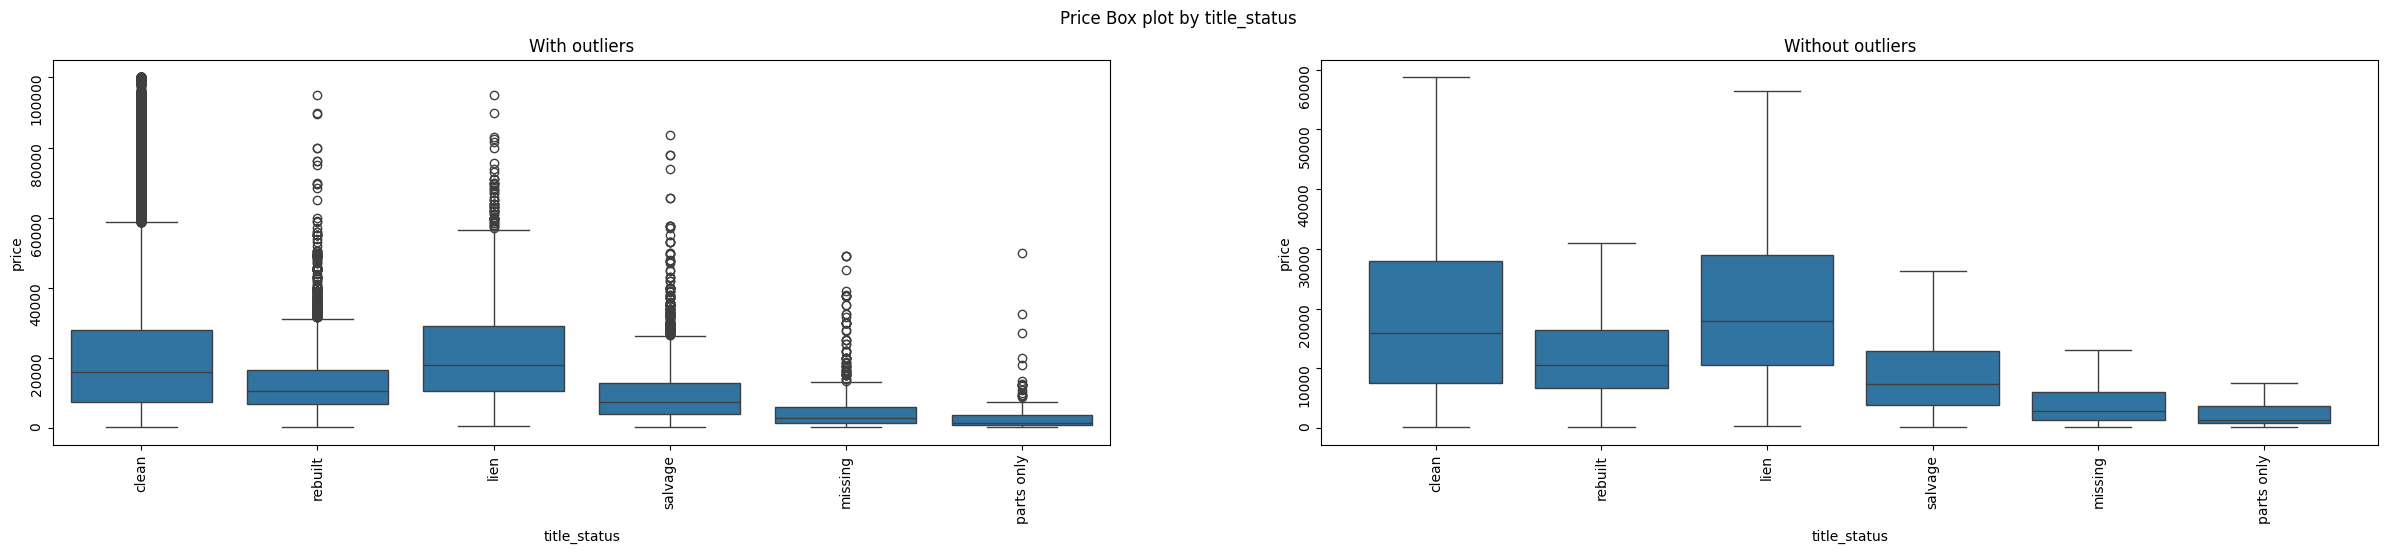

In [597]:
plot_box_price_feature(data1,'title_status')

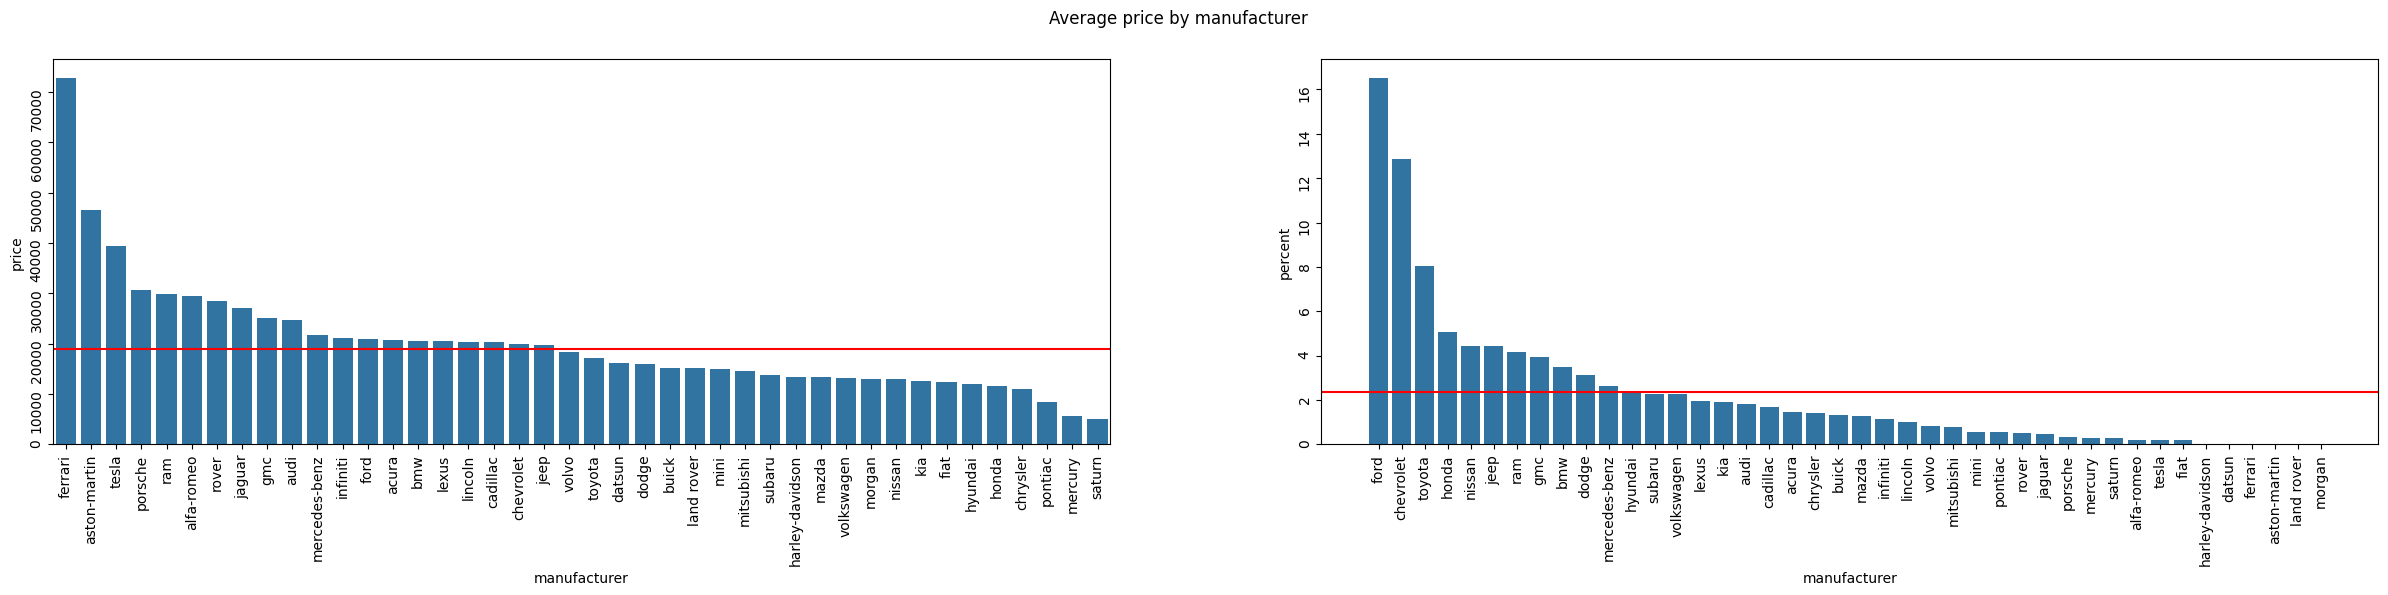

In [598]:
# by manufacturer
plot_avg_price_feature(data1,'manufacturer')

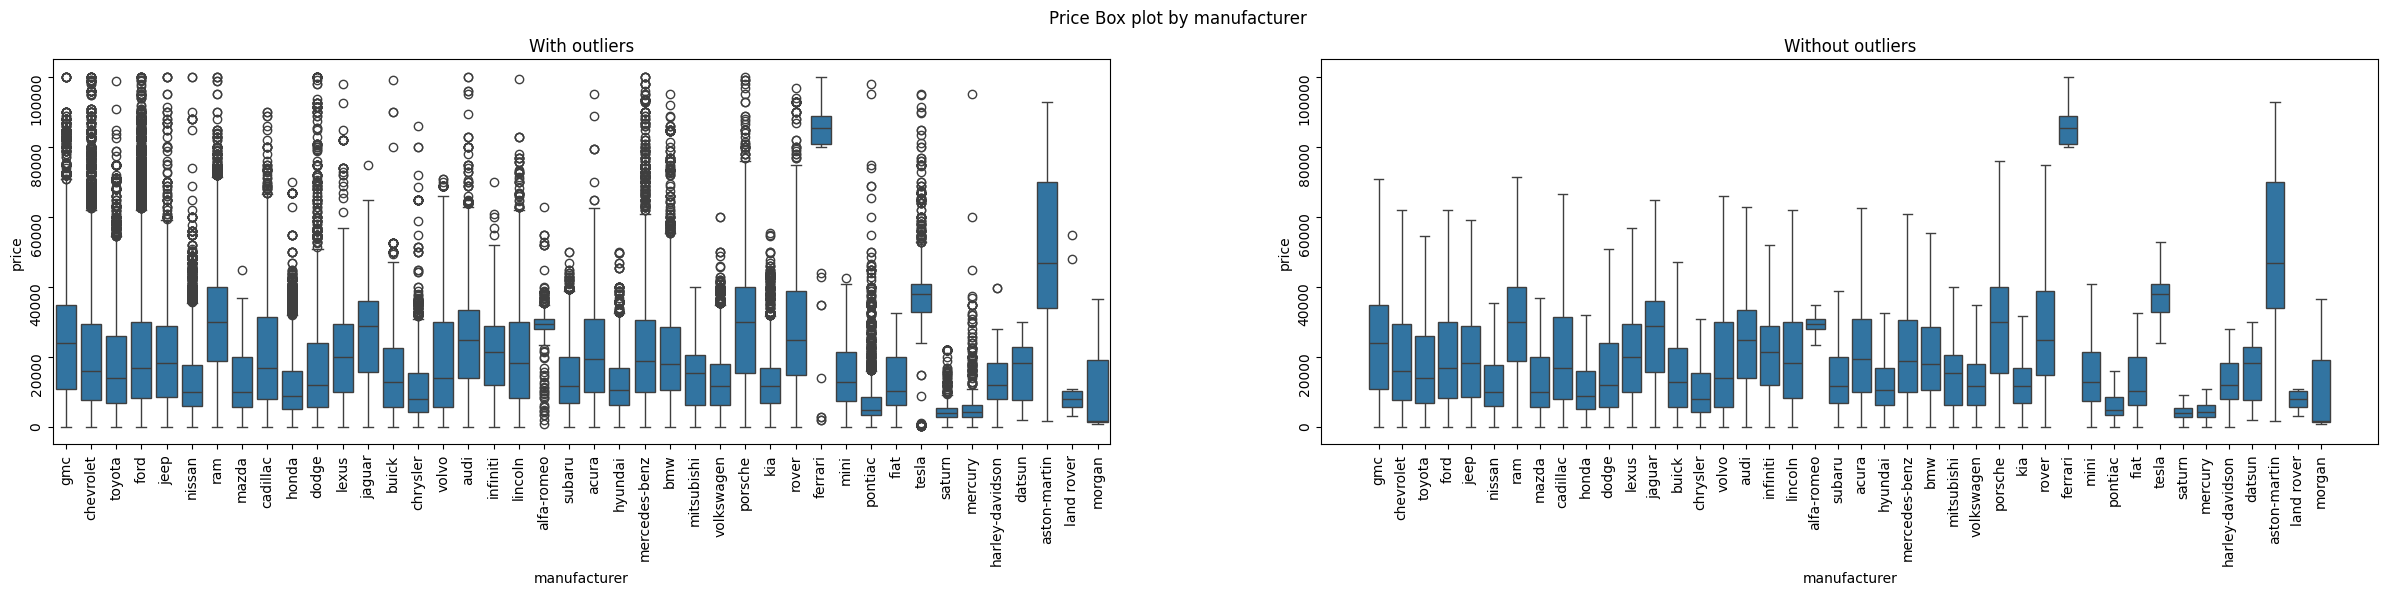

In [599]:
plot_box_price_feature(data1,'manufacturer')

#### Odometer analysis

In [437]:
data['odometer'].describe()

count     391695.000
mean       98729.511
std       205915.786
min            0.000
25%        38000.000
50%        87000.000
75%       135334.000
max     10000000.000
Name: odometer, dtype: float64

[]

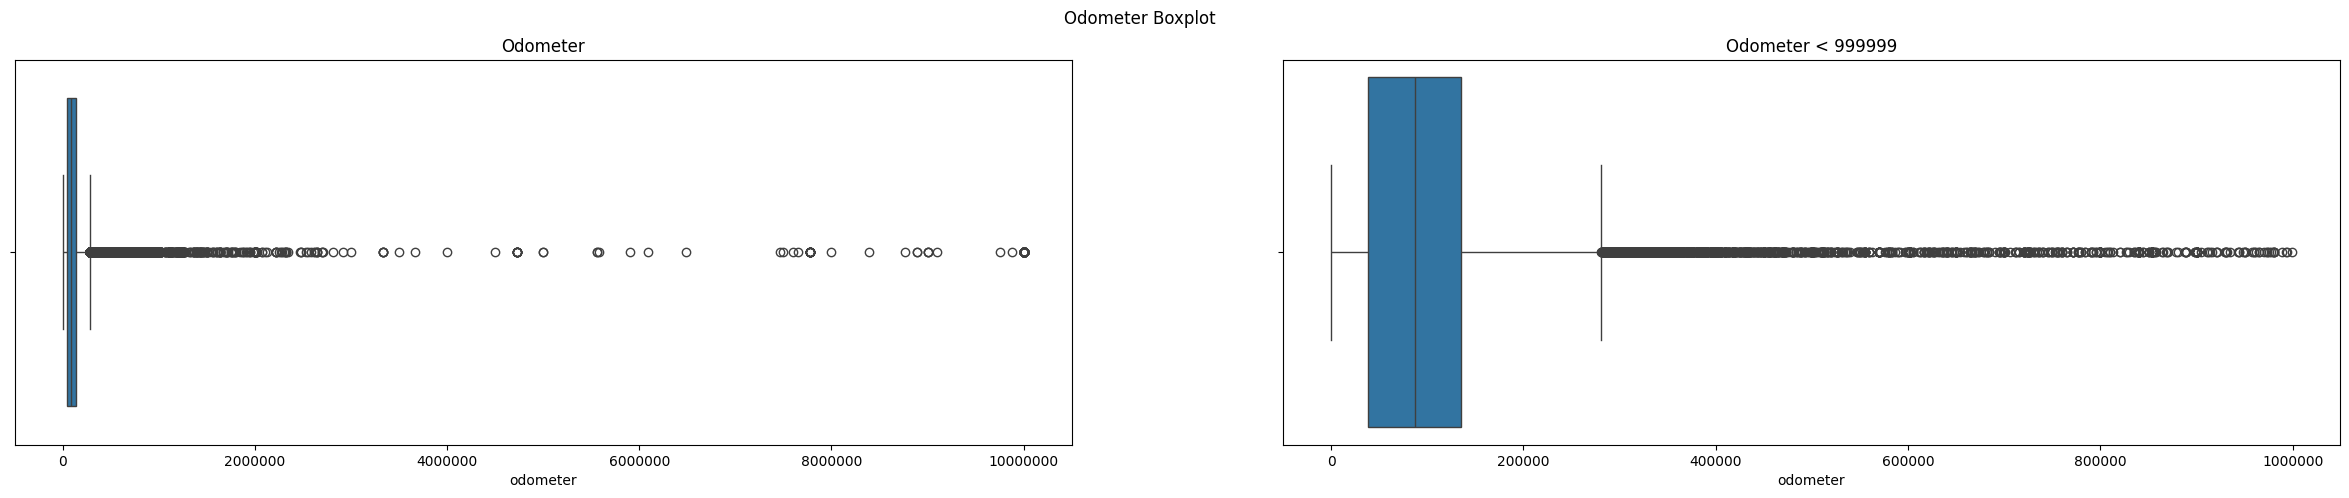

In [604]:
# Boxplot odometer
fig, axes = plt.subplots(1,2,figsize=(30,5))

plt.suptitle(f'Odometer Boxplot')

sns.boxplot(x=data1['odometer'],ax=axes[0])
axes[0].set_title('Odometer')
axes[0].ticklabel_format(style='plain', axis='x')

sns.boxplot(x=data1.query('odometer < 999999')['odometer'],ax=axes[1])
axes[1].set_title('Odometer < 999999')
axes[1].ticklabel_format(style='plain', axis='x')

plt.plot()

### Data Preparation
After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [673]:
# Drop columns step 1
# VIN: Vehicle Unique Identification Number - does not contribute to the model
# id: Unique identifier for each listing - does not contribute to the model
df_final = data.drop(['id','VIN'],axis=1).copy()

In [674]:
# Drop columns step 2
# Drop columns with a large number of missing values
df_final = df_final.drop(['size','cylinders','condition','drive','paint_color','type'],axis=1)

In [675]:
# Drop rows step 3
# Drop rows where price is equal to or less than 0
drop_price_0 = df_final.query('price <= 0').shape[0]
print(f'Number of rows that will be dropped because price is equal to or less than 0: {drop_price_0}')
df_final = df_final.drop(df_final.query('price <= 0').index)

Number of rows that will be dropped because price is equal to or less than 0: 32895


In [676]:
# Drop rows step 4
# Drop rows where odometer is equal to or greater than 999999
# Apparently these values are data entry errors or real outliers which will however make the model less accurate
drop_odometer_999999 = df_final.query('odometer >= 999999').shape[0]
print(f'Number of rows that will be dropped because odometer is equal to or greater than 999999: {drop_odometer_999999}')
df_final = df_final.drop(df_final.query('odometer >= 999999').index)

Number of rows that will be dropped because odometer is equal to or greater than 999999: 760


In [678]:
# Drop rows step 5
# Drop NaN rows for specif columns
# Because they are columns with categorical values, I chose not to use any input method
df_final = df_final.dropna(subset = ['region','manufacturer','model','fuel','title_status','transmission','state'])

In [681]:
print(f'Total number of dropped rows: {data.shape[0]-df_final.shape[0]}')
print(f'Total % of dropped rows: {(data.shape[0]-df_final.shape[0])/data.shape[0]*100}')

Total number of dropped rows: 64442
Total % of dropped rows: 15.096045727136431


In [618]:
df_final.query('odometer > 999999').size

5280

In [314]:
(data.isna().mean()*100).sort_values()

region          0.000
price           0.000
state           0.000
year            0.298
transmission    0.463
odometer        0.581
fuel            0.658
model           1.193
title_status    1.963
manufacturer    4.108
type           21.811
paint_color    29.734
drive          30.522
condition      38.425
cylinders      40.715
size           71.813
dtype: float64

In [326]:
data_final = data[['price','region','state','year','transmission','odometer','fuel','model','title_status','manufacturer']].copy()
data_final.shape

(393985, 10)

In [316]:
# data_final.dropna(inplace=True)
# data_final.shape

(361028, 10)

In [338]:
# Column Transformer
data_final.loc[20:30,'transmission']

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(data_final[['transmission']])
SimpleImputer()


SimpleImputer()

In [341]:
data_test = pd.DataFrame(data_final.loc[20:30,'transmission'].copy())

print(data_final.loc[20:30,'transmission'])
print(imp.transform(data_test))


20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27    other
28    other
29    other
30    other
Name: transmission, dtype: object
[['automatic']
 ['automatic']
 ['automatic']
 ['automatic']
 ['automatic']
 ['automatic']
 ['automatic']
 ['other']
 ['other']
 ['other']
 ['other']]


In [85]:

# Group by 'model' and get the most common 'size' for each model
common_size_per_model = data.groupby('model')['size'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_size_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_size_per_model[common_size_per_model.apply(len) > 1]
    print("Models with multiple mode sizes:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode size.")

# # Function to impute size
# def impute_size(row):
#     if pd.isnull(row['size']) and row['model'] in common_size_per_model:
#         return common_size_per_model[row['model']]
#     return row['size']

# # Apply the function to each row
# data['size'] = data.apply(impute_size, axis=1)

Each model has a single mode size.


In [97]:
# Group by 'model' and get the most common 'manufacturer' for each model
common_manufacturer_per_model = data.groupby('model')['manufacturer'].agg(lambda x: x.nunique())

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_manufacturer_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_manufacturer_per_model[common_manufacturer_per_model.apply(len) > 1]
    print("Models with multiple mode manufacturers:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode manufacturer.")

Each model has a single mode manufacturer.


In [88]:
# Group by 'model' and get the most common 'drive' for each model
common_drive_per_model = data.groupby('model')['drive'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_drive_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_drive_per_model[common_drive_per_model.apply(len) > 1]
    print("Models with multiple mode drives:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode drive.")

Each model has a single mode drive.


In [89]:
# Group by 'model' and get the most common 'type' for each model
common_type_per_model = data.groupby('model')['type'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_type_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_type_per_model[common_type_per_model.apply(len) > 1]
    print("Models with multiple mode types:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode type.")

Each model has a single mode type.


In [93]:
# Group by 'model' and aggregate unique values for 'size', 'manufacturer', 'drive', and 'type'
unique_values_per_model = data.groupby('model')[['size', 'manufacturer', 'drive', 'type']].agg(lambda x: x.nunique())

# Filter out models that have more than one unique value for any of these attributes
inconsistent_models = unique_values_per_model[(unique_values_per_model > 1).any(axis=1)]

# Print out the inconsistent models
if not inconsistent_models.empty:
    print("Models with inconsistency in size, manufacturer, drive, or type:")
    print(inconsistent_models)
else:
    print("Each model has consistent size, manufacturer, drive, and type.")



Models with inconsistency in size, manufacturer, drive, or type:
                size  manufacturer  drive  type
model                                          
#NAME?             1             5      3     7
-                  1             2      3     2
1                  2             0      2     3
1 1/2 ton          0             2      1     2
1 series           1             1      1     3
...              ...           ...    ...   ...
z4 convertible     3             1      1     1
z4 sdrive28i       2             1      1     1
z71                1             1      1     2
zdx                3             1      1     1
zephyr             2             2      2     1

[5476 rows x 4 columns]


In [95]:
data.query('model == "zephyr"')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
8371,7301907393,kenai peninsula,1500,1978.0,mercury,zephyr,good,8 cylinders,gas,123456.0,rebuilt,automatic,NaN,rwd,mid-size,NaN,yellow,ak
13205,7308800194,prescott,18000,1947.0,lincoln,zephyr,good,8 cylinders,gas,52235.0,clean,automatic,NaN,rwd,full-size,sedan,custom,az
139707,7312809295,champaign urbana,4990,2006.0,lincoln,zephyr,excellent,NaN,gas,110000.0,clean,automatic,NaN,NaN,full-size,sedan,NaN,il
181047,7316753132,baltimore,2100,2006.0,lincoln,zephyr,NaN,6 cylinders,gas,206089.0,clean,other,3LNHM26176R652850,fwd,NaN,sedan,black,md
181087,7316671738,baltimore,2100,2006.0,lincoln,zephyr,NaN,6 cylinders,gas,206089.0,clean,other,3LNHM26176R652850,fwd,NaN,sedan,black,md
196706,7316187579,detroit metro,5000,2007.0,lincoln,zephyr,NaN,NaN,gas,135000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,mi
202109,7308734020,grand rapids,2700,2006.0,lincoln,zephyr,NaN,NaN,gas,166000.0,clean,automatic,3LMHM26136R618520,NaN,NaN,NaN,NaN,mi
203046,7315293259,holland,4999,2006.0,lincoln,zephyr,good,6 cylinders,gas,131022.0,salvage,automatic,NaN,fwd,mid-size,sedan,NaN,mi
212030,7305640445,duluth / superior,2000,2006.0,lincoln,zephyr,fair,6 cylinders,gas,104000.0,clean,automatic,NaN,fwd,NaN,NaN,white,mn
215259,7315934532,minneapolis / st paul,6650,2006.0,lincoln,zephyr,good,4 cylinders,gas,78000.0,clean,automatic,NaN,fwd,mid-size,sedan,blue,mn


In [513]:
# Assuming 'data' is your DataFrame and it has been loaded already
# Calculate the frequency of each model
model_frequency = data['model'].value_counts(normalize=True)

# Calculate the cumulative sum of the frequencies
model_cumulative_frequency = model_frequency.cumsum()

# Find the number of models needed to reach 80% cumulative frequency
models_needed_for_80_percent = model_cumulative_frequency[model_cumulative_frequency <= 0.80].size

print(models_needed_for_80_percent)

2246


In [515]:
model_frequency.size

28265